#CS 4372.501 
#Assignment 4: Sentiment Analysis Using RNN and Naive Bayes

Due: December 4, 2022

Number of late days used: 1

Members: Myanh Tran, Enrique Cardenas III

##Import libraries

In [ ]:
#import libraries
import os, gc, glob, cv2, PIL, PIL.Image, pathlib, tarfile, random, datetime, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from os import path
from zipfile import ZipFile
from google.colab import files
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split

random.seed(24)
warnings.filterwarnings("ignore")

##Get data from Box 

In [ ]:
!wget https://utdallas.box.com/shared/static/3l9r0twua21epvi3f9m53n66647myu18.zip

--2023-04-08 14:08:04--  https://utdallas.box.com/shared/static/3l9r0twua21epvi3f9m53n66647myu18.zip
Resolving utdallas.box.com (utdallas.box.com)... 74.112.186.144
Connecting to utdallas.box.com (utdallas.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/3l9r0twua21epvi3f9m53n66647myu18.zip [following]
--2023-04-08 14:08:04--  https://utdallas.box.com/public/static/3l9r0twua21epvi3f9m53n66647myu18.zip
Reusing existing connection to utdallas.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://utdallas.app.box.com/public/static/3l9r0twua21epvi3f9m53n66647myu18.zip [following]
--2023-04-08 14:08:05--  https://utdallas.app.box.com/public/static/3l9r0twua21epvi3f9m53n66647myu18.zip
Resolving utdallas.app.box.com (utdallas.app.box.com)... 74.112.186.144
Connecting to utdallas.app.box.com (utdallas.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting 

In [ ]:
file_name = '/content/3l9r0twua21epvi3f9m53n66647myu18.zip'
with ZipFile(file_name, 'r') as zips: zips.extractall()

In [ ]:
amazondata = pd.read_csv('/content/sentiment labelled sentences/amazon_cells_labelled.txt', sep='\t', header=None, names = ['text', 'sentiment'])

In [ ]:
amazondata

,text,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


##Encode labels

In [ ]:
encodeSentiment = {1: "Good vibe", 0: "Bad vibe"}
def encodeLabel(label): return encodeSentiment[label]

amazondata.sentiment = amazondata.sentiment.apply(lambda d: encodeLabel(d))
count = amazondata.sentiment.value_counts()
amazondata

,text,sentiment
0,So there is no way for me to plug it in here i...,Bad vibe
1,"Good case, Excellent value.",Good vibe
2,Great for the jawbone.,Good vibe
3,Tied to charger for conversations lasting more...,Bad vibe
4,The mic is great.,Good vibe
...,...,...
995,The screen does get smudged easily because it ...,Bad vibe
996,What a piece of junk.. I lose more calls on th...,Bad vibe
997,Item Does Not Match Picture.,Bad vibe
998,The only thing that disappoint me is the infra...,Bad vibe


Text(0.5, 1.0, 'Sentiments distribution')

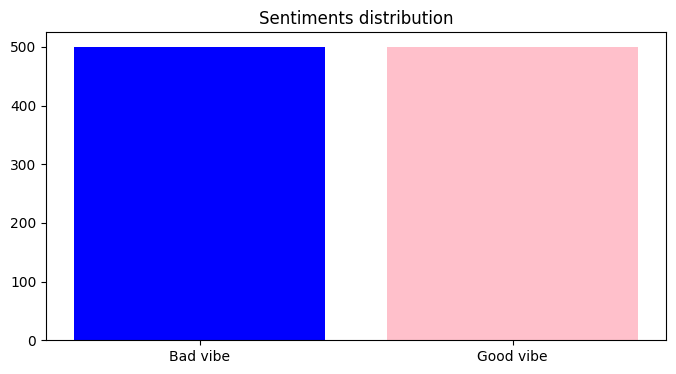

In [ ]:
# Plots of distributions
plt.figure(figsize=(8,4))
plt.bar(count.index, count.values, color = ['blue', 'pink'])
plt.title("Sentiments distribution")

##Split train/test set

In [ ]:
X = amazondata['text']
y = amazondata['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_test_orig = X_test
X_train

,text
716,It quit working after I'd used it for about 18...
351,Works like a charm.. Works as advertised.
936,I kept catching the cable on the seat and I ha...
256,"The cable looks so thin and flimsy, it is scary."
635,im surprised this is a good quality car charge...
...,...
106,That's a huge design flaw (unless I'm not usin...
270,"Not only will it drain your player, but may al..."
860,Last time buying from you.
435,Warning - Stay away.


##Plot positive words for fun


Sentiment = 0: Bad vibe

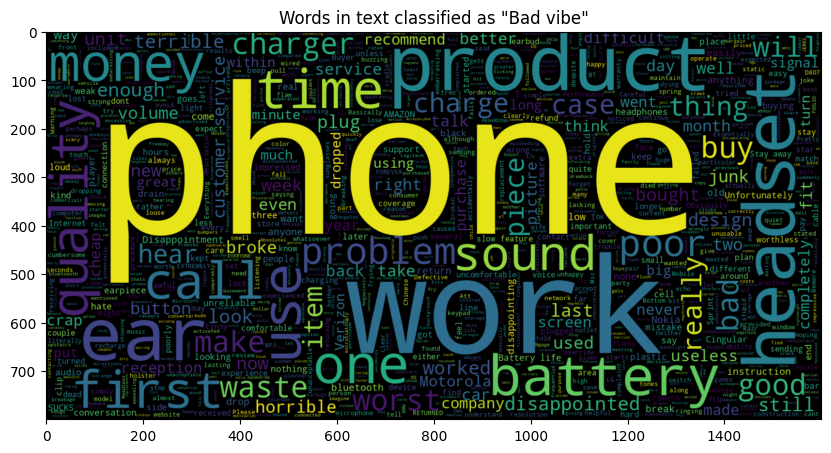

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(amazondata[amazondata.sentiment == 'Bad vibe'].text))
plt.title('Words in text classified as "Bad vibe"')
plt.imshow(wc , interpolation = 'bilinear')

Sentiment = 0: Good vibe

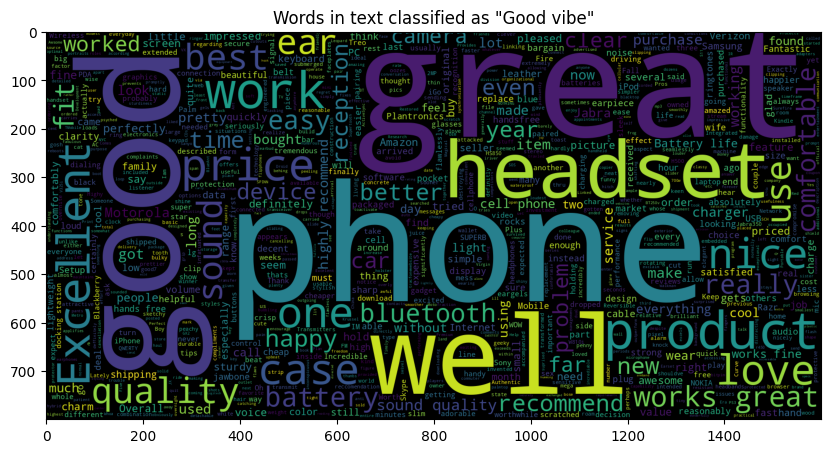

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(amazondata[amazondata.sentiment == 'Good vibe'].text))
plt.title('Words in text classified as "Good vibe"')
plt.imshow(wc)

##Token text
Split words in each sample then index them to vocabulary index

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.text)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
vocab_size

1770

##Pad sequence 
Number of words in each observation may be different and less than time_step, therefore, we will add padding to maintain equal length across all samples

After tokenzing words to indexed words, we will transform the whole text to sequence of those index numbers that mapped to vocabulary

In [ ]:
#!pip install pad_sequences
from keras_preprocessing.sequence import pad_sequences
PADDING = 40

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train.text), maxlen = PADDING)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test.text), maxlen = PADDING)
X_train.shape 

ModuleNotFoundError: ignored

In [ ]:
labels = y_train.unique().tolist()
labels

##Label Encoding 
Encode the binary labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_train.to_list())
y_train = encoder.transform(y_train.to_list())
y_test = encoder.transform(y_test.to_list())

In [ ]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_train.shape, y_test.shape

##Word Embedding 
Apply this to allow words have similar meanings have similar representation by mapping each to a vector

Transfer Learning GloVe Embedding from Stanford AI 

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!unzip glove.6B.zip

Let open the Glove transfer learning 

In [ ]:
GLOVE_EMBEDDING = '/content/glove.6B.300d.txt'
EMD_DIM = 300

In [ ]:
embedding_index = {}
f = open(GLOVE_EMBEDDING)
for line in f:
  values = line.split()
  word = value = values[0]
  coefficients = np.asarray(values[1:], dtype = 'float32')
  embedding_index[word] = coefficients
f.close()

len(embedding_index)

So GloVE transfer learning has 40000 word vectors

In [ ]:
embedding_matrix = np.zeros((vocab_size, EMD_DIM))
for word, i in word_index.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, EMD_DIM, weights = [embedding_matrix], input_length = PADDING, trainable = False)

##LSTM

In [ ]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
sequence_input = Input(shape = (PADDING, ), dtype = 'float32')
embedding_sequence = embedding_layer(sequence_input)
layer = Conv1D(64, 5, activation = 'relu')(embedding_sequence)
layer = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(layer)
layer = Dense(512, activation = 'relu')(layer)
output = Dense(1, activation = 'sigmoid')(layer)
model = tf.keras.Model(sequence_input, output)

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs = 5, validation_data = (X_test, y_test))

Plots of train and validation accuracies and losses.

In [ ]:
import matplotlib.pyplot as plt

train_accuracy = [None] + history.history['accuracy']
val_accuracy = [None] + history.history['val_accuracy']

plt.figure(figsize=(10,4))
plt.plot(train_accuracy, linestyle = '--', marker = 'o', c = 'orange')
plt.plot(val_accuracy, marker = 'o', c = 'b')
plt.title('Model accuracy through epochs')
plt.ylim([0,1])
plt.xticks(range(1,6))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
train_loss = [None] + history.history['loss']
val_loss = [None] + history.history['val_loss']

plt.figure(figsize=(10,4))
plt.plot(train_loss, linestyle = '--', marker = 'o', color = 'pink')
plt.plot(val_loss, marker = 'o', c = 'green')
plt.title('Model loss through epochs')
plt.xticks(range(1,6))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

Here, we will look at 10 predictions that were misclassified.

In [ ]:
def decode_sentiment(score): return 'Negative' if score > 0.5 else 'Positive'

scores = model.predict(X_test, verbose = 1, batch_size = 10000)
LTSM_preds = [decode_sentiment(score) for score in scores]
LTSM_preds[:10]

In [ ]:
temp_y_test = []
labeled_y_test = []
for ix in y_test: temp_y_test.append(ix[0])
for ix in temp_y_test: labeled_y_test.append('Negative' if ix == 1 else 'Positive')
labeled_y_test[:10]

In [ ]:
pd.set_option('display.max_colwidth', None)
# Create new columns for actual vs predicted labels
X_test_orig['Actual'] = labeled_y_test
X_test_orig['Predicted'] = LTSM_preds
# Get 10 predictions that the model got wrong
LTSM_wrong_preds = X_test_orig[X_test_orig['Actual'] != X_test_orig['Predicted']]
LTSM_wrong_preds.head(10)

##Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
naive = MultinomialNB()
params = {'alpha':[0.3, 0.1, 0.001, 0.0001], 'fit_prior':[True,False]}
grid = GridSearchCV(naive, params, scoring = 'accuracy', cv = 10, return_train_score=True)

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
#predictions = naive.predict(X_test)
print(grid.score(X_test, y_test))

In [ ]:
print(grid.best_params_)

In [ ]:
NB_predictions = grid.predict(X_test)
NB_predictions = NB_predictions.flatten()
NB_predictions = np.where(NB_predictions > 0.5, 1, 0)
print(classification_report(y_test, NB_predictions))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confuse_matrix = confusion_matrix(y_test, NB_predictions)
sns.heatmap(confuse_matrix.T)
plt.xlabel('true label')
plt.ylabel('predicted label');
print(confuse_matrix)

Here, we will look at 10 predictions that were misclassified.

In [ ]:
# Convert to named labels
labeled_y_test = []
labeled_NB_predictions = []
for idx,ix in enumerate(temp_y_test): 
  labeled_y_test.append('Negative' if ix == 1 else 'Positive')
  labeled_NB_predictions.append('Negative' if NB_predictions[idx] == 1 else 'Positive')
labeled_NB_predictions[:10]

In [ ]:
labeled_y_test[:10]

In [ ]:
# Create new columns for actual vs predicted labels
X_test_orig.drop(columns = ['Actual','Predicted'], inplace = True)
X_test_orig['Actual'] = labeled_y_test
X_test_orig['Predicted'] = labeled_NB_predictions
# Get 10 predictions that the model got wrong
NB_wrong_preds = X_test_orig[X_test_orig['Actual'] != X_test_orig['Predicted']]
NB_wrong_preds.head(10)